In [1]:
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore')

/Users/johndimarco/anaconda3/envs/lending_club/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data_path = Path('data')

In [3]:
x_cols = ['loan_amnt','purpose','grade','sub_grade','int_rate','term','installment',
           'home_ownership','emp_length','annual_inc', 'annual_inc_joint','dti_joint',
           'dti','zip_code','addr_state','fico_range_low','fico_range_high',
           'earliest_cr_line','open_acc','total_acc','revol_bal','revol_util',
           'inq_last_6mths','acc_now_delinq','delinq_amnt',
           'delinq_2yrs','mths_since_last_delinq','pub_rec','mths_since_last_record',
           'mths_since_last_major_derog','collections_12_mths_ex_med','verification_status',
           'total_pymnt', 'total_rec_int','total_rec_late_fee','total_rec_prncp']

In [4]:
train_df = pd.read_pickle('data/api_train_df.pkl').iloc[:,3:]
val_df = pd.read_pickle('data/api_val_df.pkl').iloc[:,3:]
test_df = pd.read_pickle('data/api_test_df.pkl').iloc[:,3:]

In [5]:
train_df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,zip_code,addr_state,initial_list_status,emp_title,acc_now_delinq,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,bc_util,dti,delinq_2yrs,delinq_amnt,earliest_cr_line,...,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,revol_bal_joint,open_act_il,sec_app_open_act_il,issue_d,loan_status,total_pymnt,total_rec_int,total_rec_late_fee,total_rec_prncp
128412,12000,36,7.62,373.94,A,A3,3 years,MORTGAGE,96500.0,Not Verified,Borrower added on 12/31/13 > Bought a new ho...,debt_consolidation,782xx,TX,f,Systems Engineer,0,4.0,2441.0,100.0,83.5,12.61,0,0,123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,13397.539998,1397.54,0.0,12000.0
128413,27050,36,10.99,885.46,B,B2,10+ years,OWN,55000.0,Verified,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,481xx,MI,w,Team Leadern Customer Ops & Systems,0,3.0,16473.0,25.0,53.9,22.87,0,0,326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,31752.530000,4702.53,0.0,27050.0
128414,12000,36,11.99,398.52,B,B3,10+ years,MORTGAGE,130000.0,Source Verified,NaN,debt_consolidation,809xx,CO,f,LTC,0,4.0,3567.0,1.0,93.0,13.03,0,0,192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,14346.479050,2346.48,0.0,12000.0
128415,28000,36,7.62,872.52,A,A3,5 years,MORTGAGE,325000.0,Source Verified,NaN,debt_consolidation,945xx,CA,w,Area Sales Manager,0,6.0,13901.0,16.7,67.1,18.55,0,0,228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,29150.980000,1150.98,0.0,28000.0
128417,12000,36,10.99,392.81,B,B2,4 years,RENT,60000.0,Not Verified,Borrower added on 12/31/13 > I would like to...,debt_consolidation,281xx,NC,f,Project Manager,0,8.0,15216.0,0.0,15.9,4.62,0,0,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,13988.609996,1988.61,0.0,12000.0


In [6]:
# def transforms(df):
#     df['lti'] = df['installment'] / df['annual_inc']
#     df['nti'] = df['lti'] + df['dti']
#     df['revol_util'] = df['revol_util'].str[:-1].astype(float)
#     df['rti'] = df['revol_bal'] / df['annual_inc']
#     df['nl_rat'] = df['lti'] / df['dti']
#     df['total_debt'] = df['dti'] * df['annual_inc']
#     df['bal_per_acc'] = df['total_debt'] / df['open_acc']
#     df['rev_per_acc'] = df['revol_bal'] / df['open_acc']
#     df['rev_p_total'] = df['revol_bal'] / df['total_debt']
#     return df

# train_df = transforms(train_df)

# val_df = transforms(val_df)

# test_df = transforms(test_df)

In [7]:
train_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       ...
       'sec_app_mths_since_last_major_derog', 'revol_bal_joint', 'open_act_il',
       'sec_app_open_act_il', 'issue_d', 'loan_status', 'total_pymnt',
       'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp'],
      dtype='object', length=109)

In [14]:
to_drop = ['member_id','issue_d','desc','loan_status', 'total_pymnt','total_rec_int','total_rec_late_fee','total_rec_prncp']

In [13]:
train_df['pct_rtn'] = (train_df['total_pymnt']/train_df['loan_amnt'])**(1/3)-1

In [18]:
(4702.53/27050)/3

0.057948613678373374

In [20]:
train_df.loc[train_df['loan_status']=='Fully Paid','total_pymnt'].sum()/train_df.loc[train_df['loan_status']=='Fully Paid','loan_amnt'].sum()

1.168021796303288

In [21]:
12000+2346.48

14346.48

In [14]:
train_df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,zip_code,addr_state,initial_list_status,emp_title,acc_now_delinq,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,bc_util,dti,delinq_2yrs,delinq_amnt,earliest_cr_line,...,all_util,inq_fi,total_cu_tl,inq_last_12m,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,revol_bal_joint,open_act_il,sec_app_open_act_il,issue_d,loan_status,total_pymnt,total_rec_int,total_rec_late_fee,total_rec_prncp,pct_rtn
128412,12000,36,7.62,373.94,A,A3,3 years,MORTGAGE,96500.0,Not Verified,Borrower added on 12/31/13 > Bought a new ho...,debt_consolidation,782xx,TX,f,Systems Engineer,0,4.0,2441.0,100.0,83.5,12.61,0,0,123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,13397.539998,1397.54,0.0,12000.0,0.037404
128413,27050,36,10.99,885.46,B,B2,10+ years,OWN,55000.0,Verified,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,481xx,MI,w,Team Leadern Customer Ops & Systems,0,3.0,16473.0,25.0,53.9,22.87,0,0,326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,31752.530000,4702.53,0.0,27050.0,0.054882
128414,12000,36,11.99,398.52,B,B3,10+ years,MORTGAGE,130000.0,Source Verified,NaN,debt_consolidation,809xx,CO,f,LTC,0,4.0,3567.0,1.0,93.0,13.03,0,0,192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,14346.479050,2346.48,0.0,12000.0,0.061340
128415,28000,36,7.62,872.52,A,A3,5 years,MORTGAGE,325000.0,Source Verified,NaN,debt_consolidation,945xx,CA,w,Area Sales Manager,0,6.0,13901.0,16.7,67.1,18.55,0,0,228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,29150.980000,1150.98,0.0,28000.0,0.013519
128417,12000,36,10.99,392.81,B,B2,4 years,RENT,60000.0,Not Verified,Borrower added on 12/31/13 > I would like to...,debt_consolidation,281xx,NC,f,Project Manager,0,8.0,15216.0,0.0,15.9,4.62,0,0,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,13988.609996,1988.61,0.0,12000.0,0.052441


In [8]:
train_df.

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,zip_code,addr_state,initial_list_status,emp_title,acc_now_delinq,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,bc_util,dti,delinq_2yrs,delinq_amnt,earliest_cr_line,...,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,revol_bal_joint,open_act_il,sec_app_open_act_il,issue_d,loan_status,total_pymnt,total_rec_int,total_rec_late_fee,total_rec_prncp
128412,12000,36,7.62,373.94,A,A3,3 years,MORTGAGE,96500.0,Not Verified,Borrower added on 12/31/13 > Bought a new ho...,debt_consolidation,782xx,TX,f,Systems Engineer,0,4.0,2441.0,100.0,83.5,12.61,0,0,123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,13397.539998,1397.54,0.0,12000.0
128413,27050,36,10.99,885.46,B,B2,10+ years,OWN,55000.0,Verified,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,481xx,MI,w,Team Leadern Customer Ops & Systems,0,3.0,16473.0,25.0,53.9,22.87,0,0,326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,31752.530000,4702.53,0.0,27050.0
128414,12000,36,11.99,398.52,B,B3,10+ years,MORTGAGE,130000.0,Source Verified,NaN,debt_consolidation,809xx,CO,f,LTC,0,4.0,3567.0,1.0,93.0,13.03,0,0,192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,14346.479050,2346.48,0.0,12000.0
128415,28000,36,7.62,872.52,A,A3,5 years,MORTGAGE,325000.0,Source Verified,NaN,debt_consolidation,945xx,CA,w,Area Sales Manager,0,6.0,13901.0,16.7,67.1,18.55,0,0,228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,29150.980000,1150.98,0.0,28000.0
128417,12000,36,10.99,392.81,B,B2,4 years,RENT,60000.0,Not Verified,Borrower added on 12/31/13 > I would like to...,debt_consolidation,281xx,NC,f,Project Manager,0,8.0,15216.0,0.0,15.9,4.62,0,0,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-01,Fully Paid,13988.609996,1988.61,0.0,12000.0


In [15]:
y_col = train_df.loan_status
x_cols = [x for x in list(train_df.columns) if x not in to_drop]
x_cols

['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'emp_title',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'bc_open_to_buy',
 'percent_bc_gt_75',
 'bc_util',
 'dti',
 'delinq_2yrs',
 'delinq_amnt',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'mths_since_recent_bc',
 'mort_acc',
 'open_acc',
 'pub_rec',
 'total_bal_ex_mort',
 'revol_bal',
 'revol_util',
 'total_bc_limit',
 'total_acc',
 'total_il_high_credit_limit',
 'num_rev_accts',
 'mths_since_recent_bc_dlq',
 'pub_rec_bankruptcies',
 'num_accts_ever_120_pd',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'tax_liens',
 'mths_since_last_major_derog',
 'num_sats',
 'num_tl_op_past_12m',
 'mo_sin_rcnt_tl',
 'tot_

In [16]:
# x_cols = ['loan_amnt','purpose','grade','sub_grade','int_rate','term','installment',
#           'home_ownership','emp_length','annual_inc', #annual_inc_joint','dti_joint',
#           'dti','zip_code','addr_state','fico_range_low','fico_range_high',
#           'earliest_cr_line','open_acc','total_acc','revol_bal','revol_util',
#           'inq_last_6mths','acc_now_delinq','delinq_amnt',
#           'delinq_2yrs','mths_since_last_delinq','pub_rec','mths_since_last_record',
#           'mths_since_last_major_derog','collections_12_mths_ex_med','verification_status',]
# #           'lti','nti','revol_util','rti','nl_rat','total_debt','bal_per_acc',
# #           'rev_per_acc','rev_p_total']

In [17]:
for col in x_cols:
    if train_df[col].dtype == object:
        print(col)

grade
sub_grade
emp_length
home_ownership
verification_status
purpose
zip_code
addr_state
initial_list_status
emp_title
application_type
verification_status_joint
sec_app_earliest_cr_line


In [18]:
# sklearn issues with Nans
# create encoding dict from train then map val
# cat enc holds encoding codes for each column
cat_encs = {}
for col in x_cols:
    if train_df[col].dtype == object:
        cat_encs[col] = dict(zip(train_df[col].unique(), range(len(train_df[col].unique()))))
for col in cat_encs.keys():
    val_df[col] = val_df[col].map(cat_encs[col], na_action='UNK')
    train_df[col] = train_df[col].map(cat_encs[col], na_action='UNK')

In [19]:
cat_encs

{'grade': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'F': 6},
 'sub_grade': {'A3': 0,
  'B2': 1,
  'B3': 2,
  'C3': 3,
  'B5': 4,
  'C1': 5,
  'A2': 6,
  'B4': 7,
  'C2': 8,
  'A5': 9,
  'B1': 10,
  'C5': 11,
  'A1': 12,
  'C4': 13,
  'D5': 14,
  'E1': 15,
  'D4': 16,
  'D3': 17,
  'A4': 18,
  'E4': 19,
  'D2': 20,
  'D1': 21,
  'E2': 22,
  'G1': 23,
  'F1': 24,
  'F4': 25,
  'E3': 26,
  'E5': 27,
  'F3': 28,
  'F2': 29,
  'F5': 30,
  'G2': 31,
  'G3': 32,
  'G5': 33,
  'G4': 34},
 'emp_length': {'3 years': 0,
  '10+ years': 1,
  '5 years': 2,
  '4 years': 3,
  '1 year': 4,
  '2 years': 5,
  '7 years': 6,
  '9 years': 7,
  '8 years': 8,
  '< 1 year': 9,
  nan: 10,
  '6 years': 11},
 'home_ownership': {'MORTGAGE': 0, 'OWN': 1, 'RENT': 2, 'NONE': 3, 'OTHER': 4},
 'verification_status': {'Not Verified': 0,
  'Verified': 1,
  'Source Verified': 2},
 'purpose': {'debt_consolidation': 0,
  'other': 1,
  'home_improvement': 2,
  'credit_card': 3,
  'small_business': 4,
  'house': 5,
  '

In [20]:
cat_encs['purpose']

{'debt_consolidation': 0,
 'other': 1,
 'home_improvement': 2,
 'credit_card': 3,
 'small_business': 4,
 'house': 5,
 'moving': 6,
 'medical': 7,
 'car': 8,
 'major_purchase': 9,
 'vacation': 10,
 'renewable_energy': 11,
 'wedding': 12,
 'educational': 13}

In [21]:
# #Convert string columns to categorical in train data
# for n,c in train_df[x_cols].items():
#     if pd.api.types.is_string_dtype(c):
#         #print(n)
#         train_df[n] = c.astype('category').cat.as_ordered()

# #Convert cat columns in test using same test categories
# for n,c in val_df[x_cols].items():
#     if (n in train_df.columns) and (train_df[n].dtype.name=='category'):
#         #print(n)
#         val_df[n] = c.astype('category').cat.as_ordered()
#         val_df[n].cat.set_categories(train_df[n].cat.categories,ordered=True,inplace=True)
        

# max_n_cat = 100000
# cat_codes = []
# for n, c in train_df[x_cols].items():
#     if not pd.api.types.is_numeric_dtype(c) and len(c.cat.categories)<max_n_cat:
#         #print(n)
#         cat_codes.append({n: list(c.cat.categories)})
#         train_df[n] = pd.Categorical(train_df[n]).codes
#         val_df[n] = pd.Categorical(val_df[n]).codes

In [22]:
x_train = train_df[x_cols]
y_train = train_df['loan_status']

x_val = val_df[x_cols]
y_val = val_df['loan_status']

y_train = y_train.map({'Fully Paid': 0, 'Charged Off': 1})
y_val = y_val.map({'Fully Paid': 0, 'Charged Off': 1})

In [23]:
from sklearn.metrics import roc_auc_score

In [24]:
# lgbm with default params

params = {'num_leaves': 32,
          'metric': 'auc',}

train_data = lgb.Dataset(x_train,
                         label=y_train)

val_data = lgb.Dataset(x_val,
                       label=y_val)

model = lgb.train(params,
                  train_data,
                  num_boost_round=1000,
                  valid_sets = [train_data, val_data],
                  verbose_eval=100,
                  early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.739363	valid_1's auc: 0.683181
Early stopping, best iteration is:
[91]	training's auc: 0.735301	valid_1's auc: 0.683671


In [26]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [34]:
rfx_train = x_train.fillna(value=-99)
rfx_val = x_val.fillna(value=-99)

In [35]:
rf.fit(rfx_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [36]:
roc_auc_score(y_val, rf.predict_proba(rfx_val)[:,1])

0.6486465450365273

In [37]:
fi = list(zip(model.feature_name(),model.feature_importance(importance_type='gain')))
fi.sort(key = lambda tup: tup[1], reverse=True)
fi

[('int_rate', 2257.6399905085564),
 ('annual_inc', 881.8571881055832),
 ('grade', 322.20778131484985),
 ('acc_open_past_24mths', 318.36533349752426),
 ('emp_title', 298.3071595430374),
 ('installment', 259.6485654115677),
 ('mths_since_recent_bc', 245.4717773795128),
 ('dti', 236.87178421020508),
 ('loan_amnt', 214.40649169683456),
 ('total_bc_limit', 202.05708980560303),
 ('revol_util', 180.59299755096436),
 ('bc_util', 172.8176498413086),
 ('purpose', 167.87087404727936),
 ('bc_open_to_buy', 165.0508691072464),
 ('revol_bal', 159.02897536754608),
 ('mo_sin_old_il_acct', 154.8297049999237),
 ('mo_sin_old_rev_tl_op', 150.3657386302948),
 ('fico_range_low', 131.11182022094727),
 ('earliest_cr_line', 128.788920044899),
 ('addr_state', 127.33191698789597),
 ('total_il_high_credit_limit', 122.57564973831177),
 ('inq_last_6mths', 120.49574714899063),
 ('mths_since_last_delinq', 116.63732248544693),
 ('num_tl_op_past_12m', 113.06649261713028),
 ('total_acc', 104.80399429798126),
 ('zip_code'

In [91]:
# lgbm with default params

params = {'num_leaves': 32,
          'metric': 'auc',
          'learning_rate': 0.1}

train_data = lgb.Dataset(x_train,
                         label=y_train)

val_data = lgb.Dataset(x_val,
                       label=y_val)

model = lgb.train(params,
                  train_data,
                  num_boost_round=1000,
                  valid_sets = [train_data, val_data],
                  verbose_eval=100,)
                  #early_stopping_rounds = 1000)

[100]	training's auc: 0.739363	valid_1's auc: 0.683181
[200]	training's auc: 0.778947	valid_1's auc: 0.679879
[300]	training's auc: 0.809776	valid_1's auc: 0.674251
[400]	training's auc: 0.834	valid_1's auc: 0.671503
[500]	training's auc: 0.854011	valid_1's auc: 0.667633
[600]	training's auc: 0.872305	valid_1's auc: 0.664653
[700]	training's auc: 0.887465	valid_1's auc: 0.661926
[800]	training's auc: 0.900577	valid_1's auc: 0.66022
[900]	training's auc: 0.912421	valid_1's auc: 0.658227
[1000]	training's auc: 0.923061	valid_1's auc: 0.655876


In [92]:
fi = list(zip(model.feature_name(),model.feature_importance(importance_type='gain')))
fi.sort(key = lambda tup: tup[1], reverse=True)
fi

[('int_rate', 2976.914597056806),
 ('annual_inc', 1886.6702325865626),
 ('dti', 1226.629902496934),
 ('emp_title', 1169.7875102460384),
 ('revol_util', 1129.7488292343915),
 ('zip_code', 1058.9120695069432),
 ('mo_sin_old_il_acct', 1052.0912957824767),
 ('earliest_cr_line', 947.524359729141),
 ('revol_bal', 884.6366260759532),
 ('bc_util', 883.6147639602423),
 ('installment', 882.8686024174094),
 ('mths_since_recent_bc', 863.9362311586738),
 ('bc_open_to_buy', 800.0287555716932),
 ('total_bc_limit', 759.4560925327241),
 ('mo_sin_old_rev_tl_op', 736.0553420037031),
 ('loan_amnt', 716.0445381589234),
 ('addr_state', 712.5245449692011),
 ('total_bal_ex_mort', 673.5435306690633),
 ('mths_since_last_delinq', 651.7426716722548),
 ('acc_open_past_24mths', 650.4562894664705),
 ('mths_since_recent_inq', 637.1469799429178),
 ('total_acc', 633.4199472889304),
 ('total_rev_hi_lim', 618.9081642702222),
 ('total_il_high_credit_limit', 595.8840156942606),
 ('avg_cur_bal', 564.6437877863646),
 ('fico_

In [93]:
preds = model.predict(x_val)

In [94]:
preds

array([ 0.08818176,  0.15313844,  0.14068673, ...,  0.07917613,
       -0.02961793,  0.19001042])

In [95]:
val_df['prediction'] = preds

In [96]:
val_df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,zip_code,addr_state,initial_list_status,emp_title,acc_now_delinq,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,bc_util,dti,delinq_2yrs,delinq_amnt,earliest_cr_line,...,total_cu_tl,inq_last_12m,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,revol_bal_joint,open_act_il,sec_app_open_act_il,issue_d,loan_status,total_pymnt,total_rec_int,total_rec_late_fee,total_rec_prncp,prediction,paid_issued,pct_earned
316593,10400,36,6.99,321.08,0,0,8,0.0,58000.0,0,NaN,3,493.0,3,1,NaN,0,7.0,7599.0,14.3,41.5,14.92,0,0,302,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,1,6611.690000,872.67,0.0,5217.75,0.088182,-3788.310000,-0.364261
316595,9600,36,13.66,326.53,2,3,1,2.0,69000.0,2,NaN,0,378.0,12,0,2293.0,0,8.0,6494.0,60.0,69.2,25.81,0,0,264,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,0,9973.430000,373.43,0.0,9600.00,0.153138,373.430000,0.038899
316596,7650,36,13.66,260.20,2,3,9,2.0,50000.0,2,NaN,0,132.0,27,0,8697.0,0,6.0,332.0,100.0,93.2,34.81,0,0,148,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,1,2281.980000,339.61,0.0,704.38,0.140687,-5368.020000,-0.701702
316599,17000,36,13.66,578.22,2,3,1,0.0,75000.0,1,NaN,0,305.0,5,0,2110.0,0,2.0,71.0,100.0,98.2,23.63,0,0,166,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,0,19562.310001,2562.31,0.0,17000.00,0.036389,2562.310001,0.150724
316600,23325,36,14.31,800.71,2,13,1,2.0,72000.0,2,NaN,3,206.0,21,0,5.0,0,6.0,3977.0,66.7,89.0,27.03,1,0,194,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,1,13907.790000,3061.64,0.0,7301.23,0.194884,-9417.210000,-0.403739


In [50]:
val_df['paid_issued'] = val_df['total_pymnt'] - val_df['loan_amnt']

In [54]:
val_df['pct_earned'] = val_df['paid_issued']/val_df['loan_amnt']

In [56]:
val_df['loan_status'] = val_df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

In [86]:
thresholds = [x/100 for x in range(0,100)]

In [97]:
returns = []
for thresh in thresholds:
    total_paid = val_df.loc[val_df['prediction']<=thresh, 'total_pymnt'].sum()
    total_issued = val_df.loc[val_df['prediction']<=thresh, 'loan_amnt'].sum()
    returns.append(total_paid/total_issued)

In [103]:
total_paid = val_df['total_pymnt'].sum()
total_issued = val_df['loan_amnt'].sum()

In [104]:
total_paid/total_issued

1.0900284050874223

In [105]:
import math

In [107]:
math.exp(0.09*3)

1.3099644507332473

In [101]:
val_df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,zip_code,addr_state,initial_list_status,emp_title,acc_now_delinq,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,bc_util,dti,delinq_2yrs,delinq_amnt,earliest_cr_line,...,total_cu_tl,inq_last_12m,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,revol_bal_joint,open_act_il,sec_app_open_act_il,issue_d,loan_status,total_pymnt,total_rec_int,total_rec_late_fee,total_rec_prncp,prediction,paid_issued,pct_earned
316593,10400,36,6.99,321.08,0,0,8,0.0,58000.0,0,NaN,3,493.0,3,1,NaN,0,7.0,7599.0,14.3,41.5,14.92,0,0,302,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,1,6611.690000,872.67,0.0,5217.75,0.088182,-3788.310000,-0.364261
316595,9600,36,13.66,326.53,2,3,1,2.0,69000.0,2,NaN,0,378.0,12,0,2293.0,0,8.0,6494.0,60.0,69.2,25.81,0,0,264,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,0,9973.430000,373.43,0.0,9600.00,0.153138,373.430000,0.038899
316596,7650,36,13.66,260.20,2,3,9,2.0,50000.0,2,NaN,0,132.0,27,0,8697.0,0,6.0,332.0,100.0,93.2,34.81,0,0,148,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,1,2281.980000,339.61,0.0,704.38,0.140687,-5368.020000,-0.701702
316599,17000,36,13.66,578.22,2,3,1,0.0,75000.0,1,NaN,0,305.0,5,0,2110.0,0,2.0,71.0,100.0,98.2,23.63,0,0,166,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,0,19562.310001,2562.31,0.0,17000.00,0.036389,2562.310001,0.150724
316600,23325,36,14.31,800.71,2,13,1,2.0,72000.0,2,NaN,3,206.0,21,0,5.0,0,6.0,3977.0,66.7,89.0,27.03,1,0,194,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,1,13907.790000,3061.64,0.0,7301.23,0.194884,-9417.210000,-0.403739
316601,2500,36,11.99,83.03,1,4,9,0.0,89000.0,2,NaN,2,169.0,24,0,5904.0,0,6.0,1333.0,66.7,86.4,13.77,0,0,157,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,0,2622.220000,122.22,0.0,2500.00,0.028695,122.220000,0.048888
316602,12975,36,17.86,468.17,3,14,1,2.0,60000.0,2,NaN,5,47.0,8,0,98.0,0,7.0,2604.0,0.0,52.7,22.42,0,0,190,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,1,5746.890000,1603.20,0.0,2628.14,0.220002,-7228.110000,-0.557080
316603,5250,36,11.44,172.98,1,7,5,2.0,26000.0,0,NaN,0,331.0,23,0,252.0,0,4.0,12152.0,0.0,26.8,14.36,0,0,67,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,0,5431.680000,181.68,0.0,5250.00,0.086079,181.680000,0.034606
316605,10000,36,11.99,332.10,1,4,8,2.0,90000.0,1,NaN,0,137.0,1,0,6044.0,0,0.0,324.0,100.0,98.5,8.44,0,0,137,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,1,6957.450000,1562.16,0.0,5395.29,0.064828,-3042.550000,-0.304255
316607,2000,36,15.99,70.31,3,20,6,2.0,37000.0,0,NaN,1,88.0,27,0,8173.0,0,6.0,390.0,100.0,90.2,16.19,2,0,251,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01,0,2375.950000,375.95,0.0,2000.00,0.091322,375.950000,0.187975


[]

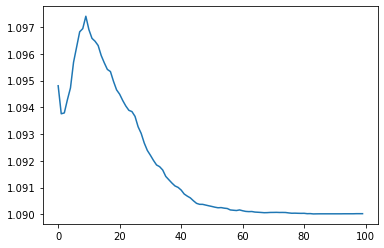

In [99]:
plt.plot(returns)

In [ ]:
plt.plot()

In [61]:
total_paid = val_df.loc[val_df['prediction']<0.05, 'total_pymnt'].sum()
total_issued = val_df.loc[val_df['prediction']<0.05, 'loan_amnt'].sum()

In [64]:
val_df['total_pymnt'].sum()/val_df['loan_amnt'].sum()

1.0900284050874223

In [62]:
total_paid/total_issued

1.0868734396836588

In [25]:
rfi = list(zip(rfx_train.columns,rf.feature_importances_))

In [26]:
rfi.sort(key = lambda tup: tup[1], reverse=True)

In [27]:
rfi

[('dti', 0.035426743404023193),
 ('annual_inc', 0.03470137648876685),
 ('revol_util', 0.03258568160556793),
 ('emp_title', 0.032503904033835594),
 ('revol_bal', 0.032006190678144225),
 ('installment', 0.03181616905092409),
 ('earliest_cr_line', 0.03156214898847698),
 ('zip_code', 0.03135261394117312),
 ('int_rate', 0.02955467141095954),
 ('loan_amnt', 0.026405113275373055),
 ('total_acc', 0.025441267997648453),
 ('addr_state', 0.022963745892814653),
 ('bc_util', 0.022089587857162182),
 ('bc_open_to_buy', 0.021808155224138658),
 ('total_bc_limit', 0.021159222198615678),
 ('total_bal_ex_mort', 0.021015972344445973),
 ('desc', 0.020487385476104486),
 ('open_acc', 0.019499234870128022),
 ('fico_range_high', 0.018729921565481977),
 ('fico_range_low', 0.018584474676070002),
 ('mths_since_recent_bc', 0.018391878271146217),
 ('emp_length', 0.018260166139398373),
 ('mo_sin_old_il_acct', 0.017481829706828163),
 ('sub_grade', 0.01737100229131288),
 ('mo_sin_old_rev_tl_op', 0.01736873683345786),
 